In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split 
from timm import create_model
import timm.optim as optim_factory
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageFilter
from tensorboardX import SummaryWriter
from torchvision.utils import make_grid
from functools import partial
from timm.models.vision_transformer import PatchEmbed, Block 
from timm.models import create_model
from util.pos_embed import get_2d_sincos_pos_embed
from PIL import Image  # Add this line to import Image module from PIL
from sklearn.metrics import accuracy_score
import pandas as pd
from PIL import ImageEnhance,Image, ImageOps
import random

/home/FYP/raja0056/.conda/envs/MAE/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gpu_available = torch.cuda.is_available()
print("GPU Available" if gpu_available else " No GPU Detected")

GPU Available


In [3]:
def show_image_with_details(img_tensor, label, img_label_mapping):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()  
    img = img * 0.229 + 0.485    
    img = np.clip(img, 0, 1) 
    plt.imshow(img)
    plt.axis('off') 
    plt.title(f"Label: {img_label_mapping[label]}, Shape: {img_tensor.shape}")
    plt.show()

img_label_mapping = {
    0: 'tench', 1: 'English springer', 2: 'cassette player', 3: 'chain saw', 
    4: 'church', 5: 'French horn', 6: 'garbage truck', 7: 'gas pump', 
    8: 'golf ball', 9: 'parachute'
}

Displaying an image from No colour:


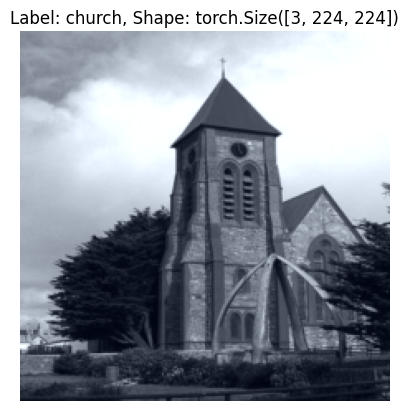

In [6]:
transform_non_colour = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: ImageEnhance.Color(img).enhance(0)),  # Low saturation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

non_colour_dataset = datasets.ImageFolder(root='../imagenette320/imagenette2-320/train',transform=transform_non_colour)

non_colour_loader = DataLoader(non_colour_dataset, batch_size=64, shuffle=True, num_workers=4)

def show_image_from_loader(loader, title="Image"):
    images, labels = next(iter(loader))  
    print(f"Displaying an image from {title}:")
    show_image_with_details(images[0], labels[0].item(), img_label_mapping)


show_image_from_loader(non_colour_loader, title="No colour")

In [5]:
# Define Masked Autoencoder ViT Model (MAE) for Pretraining
class MaskedAutoencoderViT(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3,
                 embed_dim=384, depth=6, num_heads=6,
                 decoder_embed_dim=256, decoder_depth=4, decoder_num_heads=8,
                 mlp_ratio=4., norm_layer=partial(nn.LayerNorm, eps=1e-6), norm_pix_loss=False):
        super().__init__()

        # MAE encoder specifics
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
                                     for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # MAE decoder specifics
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
                                             for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True) # decoder to patch

        self.norm_pix_loss = norm_pix_loss

        self.initialize_weights()

    def initialize_weights(self):
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        torch.nn.init.normal_(self.cls_token, std=.02)
        torch.nn.init.normal_(self.mask_token, std=.02)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def patchify(self, imgs):
        p = self.patch_embed.patch_size[0]
        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
        return x

    def unpatchify(self, x):
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
        return imgs

    def random_masking(self, x, mask_ratio):
        N, L, D = x.shape
        len_keep = int(L * (1 - mask_ratio))
        noise = torch.rand(N, L, device=x.device)
        ids_shuffle = torch.argsort(noise, dim=1)
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore

    def forward_encoder(self, x, mask_ratio):
        x = self.patch_embed(x)
        x = x + self.pos_embed[:, 1:, :]
        x, mask, ids_restore = self.random_masking(x, mask_ratio)
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        x = self.decoder_embed(x)
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))
        x = torch.cat([x[:, :1, :], x_], dim=1)

        x = x + self.decoder_pos_embed

        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        x = self.decoder_pred(x)
        x = x[:, 1:, :]
        return x

    def forward_loss(self, imgs, pred, mask):
        target = self.patchify(imgs)
        if self.norm_pix_loss:
            mean = target.mean(dim=-1, keepdim=True)
            var = target.var(dim=-1, keepdim=True)
            target = (target - mean) / (var + 1.e-6)**.5

        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)
        loss = (loss * mask).sum() / mask.sum()
        return loss

    def forward(self, imgs, mask_ratio=0.5):  #reduce mask ratio to 0.5
        latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)
        pred = self.forward_decoder(latent, ids_restore)
        loss = self.forward_loss(imgs, pred, mask)
        # Return latent and ids_restore for linear probing
        return loss, pred, mask, latent, ids_restore

In [18]:
def train_one_epoch(model, dataloader, optimizer, device, clip_value=1.0):
    model.train()
    running_loss = 0.0
    for imgs, _ in dataloader:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        loss, _, _, _, _ = model(imgs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

In [19]:
#Instantiate model and optimisers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MaskedAutoencoderViT().to(device)

# Use Adam optimizer with a learning rate of 1e-3 and weight decay
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.05) 

# Cosine Annealing scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=500) 

In [8]:
total_epochs=500
checkpoint=50

Pretrain Epoch [50/500], Loss: 0.2253
Checkpoint saved at epoch 50
Pretrain Epoch [100/500], Loss: 0.2066
Checkpoint saved at epoch 100
Pretrain Epoch [150/500], Loss: 0.1988
Checkpoint saved at epoch 150
Pretrain Epoch [200/500], Loss: 0.1934
Checkpoint saved at epoch 200
Pretrain Epoch [250/500], Loss: 0.1884
Checkpoint saved at epoch 250
Pretrain Epoch [300/500], Loss: 0.1850
Checkpoint saved at epoch 300
Pretrain Epoch [350/500], Loss: 0.1813
Checkpoint saved at epoch 350
Pretrain Epoch [400/500], Loss: 0.1798
Checkpoint saved at epoch 400
Pretrain Epoch [450/500], Loss: 0.1781
Checkpoint saved at epoch 450
Pretrain Epoch [500/500], Loss: 0.1757
Checkpoint saved at epoch 500


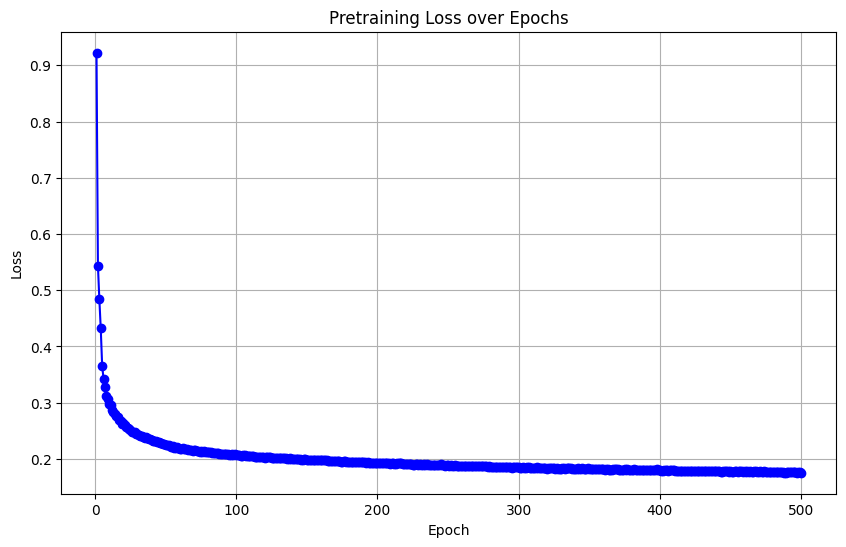

In [9]:

epoch_losses = []

# Main pretraining loop
for epoch in range(1, total_epochs + 1):
    train_loader = non_colour_loader 
    loss = train_one_epoch(model, train_loader, optimizer, device)
    epoch_losses.append(loss)

    if epoch % checkpoint == 0:
        print(f"Pretrain Epoch [{epoch}/{total_epochs}], Loss: {loss:.4f}")
        checkpoint_path = f'mae_noncolour_checkpoint_{epoch}.pth'
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch}")
    

# Save final pretrained weights
torch.save(model.state_dict(), 'mae_noncolour_500_final.pth')

# Plot pretraining loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, total_epochs + 1), epoch_losses, marker='o', linestyle='-', color='blue')
plt.title('Pretraining Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### MLP probing and testing

In [6]:
# Instantiate model and load pretrained weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MaskedAutoencoderViT().to(device)
model.load_state_dict(torch.load('mae_noncolour_500_final.pth'))

<All keys matched successfully>

In [4]:
full_val_dataset = datasets.ImageFolder(root='../imagenette320/imagenette2-320/val', transform=None)
total_size = len(full_val_dataset)
train_size = int(0.5 * total_size)
test_size = total_size - train_size
 
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.2, 1.0), interpolation=3),  
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset, test_dataset = random_split(full_val_dataset, [train_size, test_size])
train_dataset.dataset.transform = transform_train


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

In [8]:
#MLP probing
class MLPProbe(nn.Module):
    def __init__(self, base_model, num_classes=10):
        super().__init__()
        self.base_model = base_model
        self.probe = nn.Sequential(
            nn.Linear(384, 256),  #2 layer MLP
            nn.ReLU(),
            nn.Linear(256, num_classes) #2 layer MLP
        )

    def forward(self, x):
        with torch.no_grad():
            latent, _, _ = self.base_model.forward_encoder(x, mask_ratio=0)
        cls_features = latent[:, 0]
        return self.probe(cls_features)

In [9]:
mlp_probe = MLPProbe(model).to(device)
optimizer_probe = optim.Adam(mlp_probe.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [10]:
# Train MLP probe
epoch_losses = []  # Store loss per epoch
def train_probe(model, dataloader, optimizer, criterion, device, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            

        avg_loss = running_loss / len(dataloader)
        epoch_losses.append(avg_loss)
        if epoch % 10 == 0:
         print(f"MLP Probe Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
            
    # Plot the loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(range(1,epochs + 1), epoch_losses, marker='o', linestyle='-', color='b')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
          


MLP Probe Epoch [1/50], Loss: 2.2519
MLP Probe Epoch [11/50], Loss: 1.5078
MLP Probe Epoch [21/50], Loss: 1.3503
MLP Probe Epoch [31/50], Loss: 1.2609
MLP Probe Epoch [41/50], Loss: 1.1874


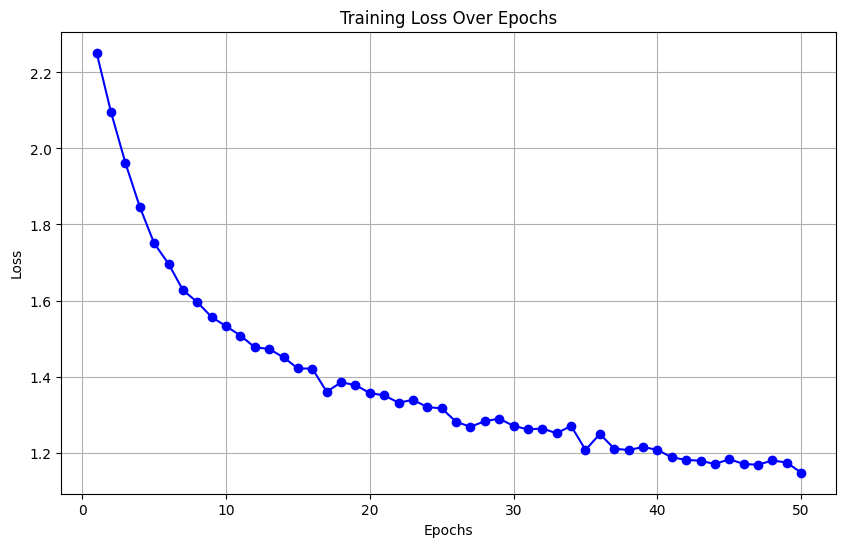

In [11]:
#train with train_loader
train_probe(mlp_probe, train_loader, optimizer_probe, criterion, device, epochs=50)

## Testing!

In [12]:
# Evaluate accuracy
def test_probe(model, dataloader, device):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

Displaying an image from Test Normal Image:


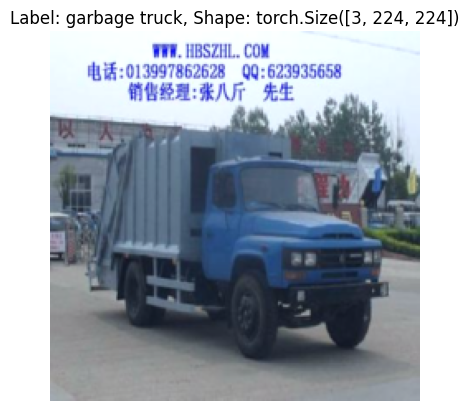

In [13]:
#Test with normal images 
transform_normal_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard ImageNet normalization
])
normal_test_dataset=test_dataset
normal_test_dataset.dataset.transform = transform_normal_test

normal_test_loader = DataLoader(normal_test_dataset, batch_size=64, shuffle=True, num_workers=4)
show_image_from_loader(normal_test_loader, title="Test Normal Image")

In [14]:
test_accuracy = test_probe(mlp_probe, normal_test_loader, device)

Test Accuracy: 52.57%


Displaying an image from White Noise Train:


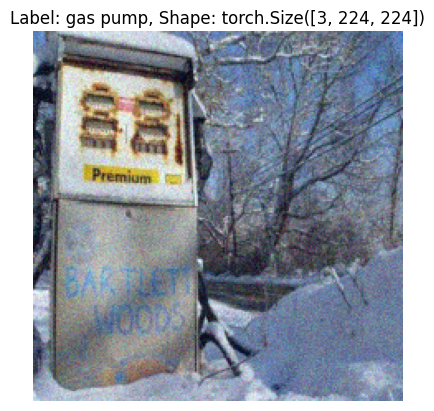

In [7]:
# Function to add white noise
def add_white_noise(img_tensor, noise_factor):
    noise = torch.randn_like(img_tensor) * noise_factor
    noisy_img = img_tensor + noise  
    return torch.clamp(noisy_img, 0.0, 1.0)  



# Data augmentation for the test set
white_transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: add_white_noise(x, noise_factor=0.05)),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

white_test_dataset = test_dataset
white_test_loader = DataLoader(white_test_dataset, batch_size=64, shuffle=False, num_workers=4)
white_test_dataset.dataset.transform = white_transform_test

white_normal_loader = DataLoader(white_test_dataset, batch_size=64, shuffle=True, num_workers=4)
show_image_from_loader(white_normal_loader, title="White Noise Train")

In [16]:
white_test_accuracy = test_probe(mlp_probe, white_test_loader, device)

Test Accuracy: 48.65%


Displaying an image from Test with black noise:


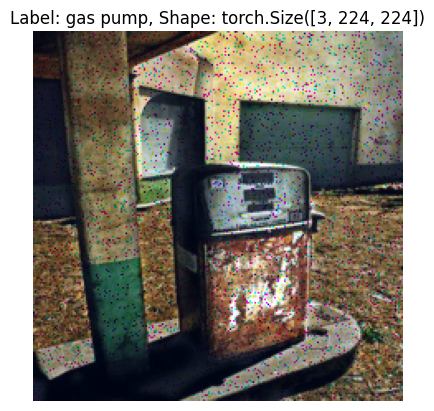

In [17]:
def add_black_noise(img_tensor, noise_factor):
    noisy_img = img_tensor.clone() 
    img_flat = noisy_img.view(-1) 
    num_black_pixels = int(noise_factor * img_flat.size(0))  
    black_pixel_indices = random.sample(range(img_flat.size(0)), num_black_pixels)   
    img_flat[black_pixel_indices] = 0  
    noisy_img = img_flat.view(*img_tensor.shape)   
     
    return noisy_img

# Data augmentation for the test set with black noise
transform_test_black_noise = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: add_black_noise(x, noise_factor=0.05)),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

black_test_dataset = test_dataset

black_test_dataset.dataset.transform =transform_test_black_noise
black_test_loader = DataLoader(black_test_dataset, batch_size=64, shuffle=False, num_workers=4)
show_image_from_loader(black_test_loader, title="Test with black noise")


In [18]:
black_test_accuracy = test_probe(mlp_probe, black_test_loader, device)

Test Accuracy: 35.66%


Displaying an image from Test with silhouette noise:


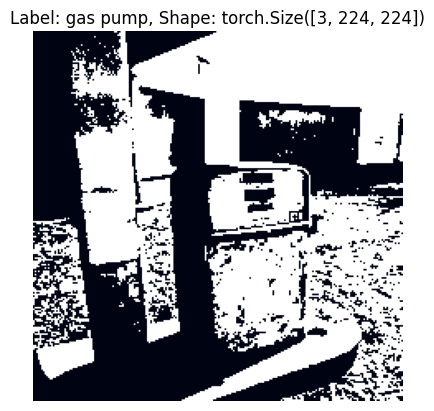

In [19]:
# Function to add silhouette effec

def add_silhouette(img_tensor, threshold=0.3):
    img_pil = transforms.ToPILImage()(img_tensor) 
    img_gray = img_pil.convert('L') 
    img_silhouette = img_gray.point(lambda p: p > threshold * 255 and 255)  
    img_silhouette_rgb = img_silhouette.convert('RGB')  
    img_silhouette_tensor = transforms.ToTensor()(img_silhouette_rgb)   
    return img_silhouette_tensor

# Data augmentation for the test set with silhouette effect
transform_test_silhouette = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: add_silhouette(x, threshold=0.3)),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

silhouette_test_dataset = test_dataset

silhouette_test_dataset.dataset.transform =transform_test_silhouette
silhouette_test_loader = DataLoader(silhouette_test_dataset, batch_size=64, shuffle=False, num_workers=4)
show_image_from_loader(silhouette_test_loader, title="Test with silhouette noise")


In [20]:
silhouette_test_accuracy = test_probe(mlp_probe, silhouette_test_loader, device)

Test Accuracy: 22.41%
